<a href="https://colab.research.google.com/github/un1qqe/DeepFake-Faces-Classification/blob/main/deepfake_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [4]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

deepfake-and-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-22 19:27:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-22 19:27:10 (38.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import unzip_data,walk_through_dir

In [6]:
unzip_data('/content/deepfake-and-real-images.zip')

In [7]:
datafake='/content/Dataset/Train/Fake/'
datareal='/content/Dataset/Train/Real/'
datatrain='/content/Dataset/Train/'
datatest='/content/Dataset/Test/'
datavalid='/content/Dataset/Validation'
datatestfake='/content/Dataset/Test/Fake'
datatestreal='/content/Dataset/Test/Real'

In [8]:
walk_through_dir(datavalid)

There are 2 directories and 0 images in '/content/Dataset/Validation'.
There are 0 directories and 19787 images in '/content/Dataset/Validation/Real'.
There are 0 directories and 19641 images in '/content/Dataset/Validation/Fake'.


In [9]:
datafake

'/content/Dataset/Train/Fake/'

In [12]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from tensorflow.keras import layers


In [10]:
def show_img(filepath):
  random_file=random.choice(os.listdir(filepath))
  random_path = os.path.join(filepath, random_file)
  random_img=tf.io.read_file(random_path)
  img=tf.io.decode_jpeg(random_img)
  img=plt.imshow(img)
  plt.axis('off')
  return img

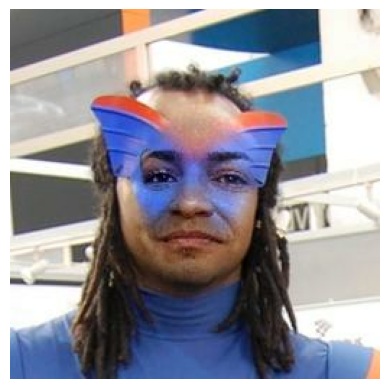

In [13]:
show_img(datafake)


In [14]:
from tensorflow.keras.preprocessing.image import  ImageDataGenerator

In [15]:
train_generator=tf.keras.preprocessing.image_dataset_from_directory(datatrain,
                                            image_size=(256,256),
                                            batch_size=32,
                                            label_mode='categorical'
                                            )

Found 140002 files belonging to 2 classes.


In [16]:
test_generator=tf.keras.preprocessing.image_dataset_from_directory(datatest,
                                           image_size=(256,256),
                                           batch_size=32,
                                           label_mode='categorical',

                                           )

Found 10905 files belonging to 2 classes.


In [17]:
test_generator.class_names

['Fake', 'Real']

In [18]:
def preprocess(filepath):
  images=[]
  for img_name in os.listdir(filepath):
    img_path=os.path.join(filepath,img_name)
    img=tf.io.read_file(img_path)
    img=tf.io.decode_jpeg(img,channels=3)
    images.append(img)
  return tf.convert_to_tensor(images)




In [19]:
def normalize(img,label):
  img=tf.cast(img,tf.float32)/255.0
  return img,label

In [20]:
train_data=train_generator.map(normalize)
test_data=test_generator.map(normalize)

In [21]:
train_generator

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

In [74]:
for i,l in train_data.take(1):
  print(i[0],l[0])

tf.Tensor(
[[[0.10588235 0.29803923 0.42745098]
  [0.10588235 0.29803923 0.42745098]
  [0.10196079 0.29411766 0.41960785]
  ...
  [0.10588235 0.28235295 0.40392157]
  [0.10588235 0.28235295 0.40392157]
  [0.10588235 0.28235295 0.40392157]]

 [[0.10588235 0.29803923 0.42745098]
  [0.10588235 0.29803923 0.42745098]
  [0.10196079 0.29411766 0.41960785]
  ...
  [0.10588235 0.28235295 0.40392157]
  [0.10588235 0.28235295 0.40392157]
  [0.10588235 0.28235295 0.40392157]]

 [[0.10588235 0.29803923 0.42352942]
  [0.10588235 0.29803923 0.42352942]
  [0.10980392 0.2901961  0.41960785]
  ...
  [0.10588235 0.28235295 0.40392157]
  [0.10588235 0.28235295 0.40392157]
  [0.10588235 0.28235295 0.40392157]]

 ...

 [[0.02745098 0.06666667 0.10588235]
  [0.01568628 0.06666667 0.10196079]
  [0.01568628 0.06666667 0.10196079]
  ...
  [0.         0.10196079 0.14509805]
  [0.01176471 0.10196079 0.13333334]
  [0.02352941 0.10196079 0.12941177]]

 [[0.01960784 0.06666667 0.11372549]
  [0.01960784 0.07450981 0

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [24]:
model_CNN = Sequential([

    Conv2D(filters = 512 , kernel_size=3, padding = 'valid', input_shape = (256, 256, 3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters = 8, kernel_size = 5,input_shape = (256, 256, 3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters= 16, kernel_size=4, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    Conv2D(filters= 32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters= 64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),

    Conv2D(filters= 128, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    Flatten(),
    tf.keras.layers.Dropout(0.3),
    Dense(units = 64, activation = 'softmax'),
    Dense(units = 20, activation = 'softmax'),
    Dense(units = 2, activation = 'softmax')
])

In [25]:
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 512)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 512)     2048      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 8)       102408    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 8)         0         
 g2D)                                                            
                                                        

In [26]:
model_CNN.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

model_CNN.fit(train_data,epochs=10,validation_data=test_data,validation_steps=int(0.5*len(test_data)),steps_per_epoch=int(0.2*len(train_data)))

Epoch 1/10
875/875 [==============================] - 375s 413ms/step - loss: 0.6488 - accuracy: 0.6829 - val_loss: 0.6305 - val_accuracy: 0.6700
Epoch 2/10
875/875 [==============================] - 356s 407ms/step - loss: 0.5372 - accuracy: 0.7622 - val_loss: 0.5649 - val_accuracy: 0.7261
Epoch 3/10
875/875 [==============================] - 355s 406ms/step - loss: 0.4801 - accuracy: 0.7833 - val_loss: 0.5359 - val_accuracy: 0.7502
Epoch 4/10
875/875 [==============================] - 355s 405ms/step - loss: 0.4337 - accuracy: 0.8051 - val_loss: 0.4714 - val_accuracy: 0.7752
Epoch 5/10
875/875 [==============================] - 353s 404ms/step - loss: 0.3958 - accuracy: 0.8226 - val_loss: 0.4589 - val_accuracy: 0.7932
Epoch 6/10
  1/875 [..............................] - ETA: 9:05 - loss: 0.1257 - accuracy: 1.0000

875/875 [==============================] - 7s 8ms/step - loss: 0.1257 - accuracy: 1.0000 - val_loss: 0.4522 - val_accuracy: 0.7969


In [27]:
validation_generator=tf.keras.preprocessing.image_dataset_from_directory(datavalid,
                                           image_size=(256,256),
                                           batch_size=32,
                                           label_mode='categorical'
                                           )

Found 39428 files belonging to 2 classes.


In [28]:
valid_data=test_generator.map(normalize)

In [29]:
model_CNN.evaluate(valid_data)

341/341 [==============================] - 15s 44ms/step - loss: 0.4622 - accuracy: 0.7919


[0.4622087776660919, 0.7919303178787231]

In [86]:
test_img=tf.io.read_file('/content/deepfakeimage/deepfake_image_2.jpg')
test_img=tf.io.decode_jpeg(test_img,channels=3)
test_img=tf.image.resize(test_img,[256,256])
test_img=tf.convert_to_tensor(test_img)
test_img=tf.expand_dims(test_img,axis=0)

In [87]:
test_img=tf.cast(test_img,tf.float32)/255.0

In [88]:
test_img.shape

TensorShape([1, 256, 256, 3])

In [89]:
preds_test=model_CNN.predict(test_img)

1/1 [==============================] - 0s 20ms/step


In [90]:
preds_test

array([[0.9930441 , 0.00695594]], dtype=float32)

In [91]:
test_generator.class_names

['Fake', 'Real']

In [92]:
preds_test[0][0]

0.9930441

In [94]:
preds_test_fake=preds_test[0][0]
preds_test_real=preds_test[0][1]

In [95]:
str(preds_test_real)[0:4]

'0.00'

In [96]:
test_img

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0.06666667, 0.07843138, 0.11372549],
         [0.06549671, 0.07798139, 0.11327551],
         [0.06029412, 0.0759804 , 0.11890319],
         ...,
         [0.04303002, 0.05479473, 0.11361826],
         [0.03921569, 0.05098039, 0.10980392],
         [0.03921569, 0.05098039, 0.10980392]],

        [[0.07107843, 0.08284314, 0.11813726],
         [0.06986826, 0.08235294, 0.11764706],
         [0.06237553, 0.07949219, 0.12193819],
         ...,
         [0.04303002, 0.05479473, 0.11361826],
         [0.03921569, 0.05098039, 0.10980392],
         [0.03921569, 0.05098039, 0.10980392]],

        [[0.07450981, 0.08627451, 0.12156863],
         [0.06986826, 0.08515433, 0.12044846],
         [0.05903799, 0.08616728, 0.12527573],
         ...,
         [0.04303002, 0.05479473, 0.11361826],
         [0.03921569, 0.05098039, 0.10980392],
         [0.03921569, 0.05098039, 0.10980392]],

        ...,

        [[0.01176471, 0.00392157, 

(-0.5, 255.5, 255.5, -0.5)

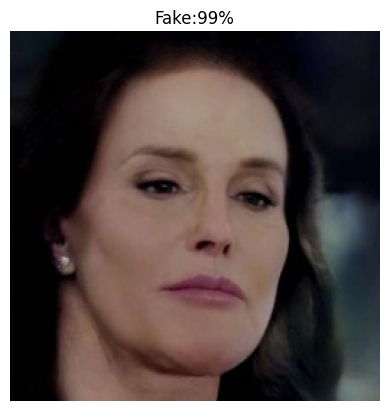

In [103]:
plt.imshow(tf.squeeze(test_img),vmin=0,vmax=1)
plt.title(f'Fake:{str(preds_test_fake)[2:4]}%')
plt.axis(False)